## Imports

In [7]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import lasagne
from lasagne.layers import *
import theano
import theano.tensor as T
from agentnet.agent import Recurrence

from collections import OrderedDict

## Data Generator

In [8]:
def generator(t = np.linspace(0,5*np.pi),p = 5,noize = 0.2):
    
    
    while True:
        
        x_prev = (np.sin(np.linspace(-np.pi*p,np.pi*p,num=32)[:,None] )+\
                 np.sin(np.linspace(-np.pi*p,np.pi*p,num=32)[None,:])) *\
                 np.sin(t[0])
            
        for t_i in t[1:]:
            x_new = (np.sin(np.linspace(-np.pi*p,np.pi*p,num=32)[:,None] )+\
                 np.sin(np.linspace(-np.pi*p,np.pi*p,num=32)[None,:])) *\
                 np.sin(t_i)

            n = np.random.normal(scale = noize,size = x_prev.shape)
                
            yield x_prev+n, x_new

            x_prev= x_new
        
        n = np.random.normal(scale = noize,size = x_prev.shape)
        yield x_new+n, x_prev

        


### Test Data

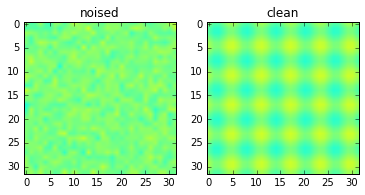

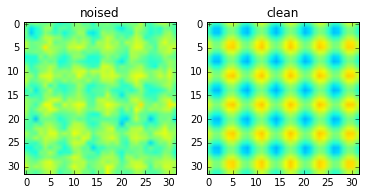

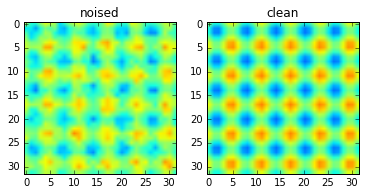

In [9]:
gen = generator()
for i in range(3):
    x,y = gen.next()
    plt.subplot(121)
    plt.imshow(x,vmin=-3,vmax=3)
    plt.title('noised')
    plt.subplot(122)
    plt.imshow(y,vmin=-3,vmax=3)
    plt.title('clean')
    plt.show()


### Goal: 
predict clean data obtaining only noised ones.

### Network Structure

In [25]:
# shape of input image
inp_shape = [32,32]

X_seq_inp = T.tensor4()
# add "1" dimension (3rd)
X_seq = X_seq_inp[:,:,None,:,:]

X_seq_layer = InputLayer([None,None,1,inp_shape[0], inp_shape[1]],input_var=X_seq,name='seq_of_inputs')

In [26]:
generator_init_var = T.tensor4()
# None - ?
generator_init = InputLayer([None,1,inp_shape[0], inp_shape[1]],generator_init_var,name='generator_init')

In [51]:
# batch size to know input size for gen part
gen_batch_size = theano.shared(1)

#### Recurrent part of NN

In [75]:
# TODO: Understand the result of Recurrence:
# Now the output is a convolution with pads
# Training: parameters of convolutions -> result - prediction

def build_recurrence(X_seq_layer,n_hidden = 8,generator_init=generator_init):
    '''
    ---------------------------------------------------------------------------------------------
    Input:
            X_seq_layer    -- sequence of input images, lasagne layer with size 5!:
                            [batch size?, nmb of input images, 1, [input_image.shape()]]
            n_hidden       -- number of hidden neurons per pixel
            generator_init -- initial input in gererative part of RNN, lasagne layer with size 4:
                            [batch size?, 1, [input_image.shape()]]
                                
    ----------------------------------------------------------------------------------------------
    Output:
            crnn_rec -- Recurrence
            crnn_gen -- Generative Recurrence
            crnn_out -- Conv2Dlayer  (X_new)
            crnn_new -- Nonlinearity (H_new)

    -----------------------------------------------------------------------------------------------
    '''
    
    
    Xi_inp = InputLayer([None,1,inp_shape[0], inp_shape[1]],name='x_i')
    
    H_prev = InputLayer([None,n_hidden,inp_shape[0], inp_shape[1]],name='hidden prev')


    # Convolution with Xi_inp: [None,1,input_shape] --> [None,n_hidden,input_shape]
    crnn_from_inp = Conv2DLayer(Xi_inp,
                                num_filters=n_hidden,
                                filter_size=[5,5],#arbitrary
                                b = None, #only apply bias once in from_hid
                                nonlinearity=None,
                                pad='same',
                                name='conv rnn input')
    
    # Convolution with H_prev: [None,n_hidden,input_shape] --> [None,n_hidden,input_shape]
    crnn_from_hid = Conv2DLayer(H_prev,
                                num_filters=n_hidden,
                                filter_size=[3,3], #arbitrary
                                nonlinearity=None,
                                pad='same',
                                name ='conv rnn hid to hid')


    crnn_sum = ElemwiseSumLayer([crnn_from_hid,crnn_from_inp])



    crnn_new = NonlinearityLayer(crnn_sum, lasagne.nonlinearities.elu)
    
    # Convolution with crnn_new.out: [None,n_hidden,input_shape] --> [None,1,input_shape]
    crnn_out = Conv2DLayer(crnn_new,
                           num_filters=1,
                           filter_size=[3,3],#arbitrary
                            nonlinearity=None, #!!! if precip.rate >0, use ReLU or similar
                            pad='same',
                            name ='conv rnn to prediction',)


    # Out of crnn_new to H_prev
    mem_dict = {crnn_new: H_prev}
    
    # Part of AgentNet: 
    # take imgs iteratively from X_seq_layer to Xi_inp n_steps times 
    # crnn_rec.outputs[0] -- tracked_outputs
    # assert (X_seq_layer.shape[2] >= n_steps)
    crnn_rec = Recurrence(input_sequences={Xi_inp:X_seq_layer},
                          tracked_outputs = crnn_out,
                         state_variables = mem_dict,
                         n_steps = 15)
    
    #-----------------------------------------------------------
    # generative part 
    
    mem_dict_generator = OrderedDict([(crnn_new, H_prev),
                                      (crnn_out,Xi_inp)])
    
    #first state
    state_init_gen = {crnn_out:generator_init}
    
    crnn_gen = Recurrence(tracked_outputs = crnn_out,
                        state_variables = mem_dict_generator,
                        n_steps = 20,
                        batch_size=gen_batch_size,
                        state_init = state_init_gen)
    #-------------------------------------------------------------
    
    return crnn_rec,crnn_gen, crnn_out,crnn_new


In [76]:
rec_layer,rec_gen_layer,X_new_layer,H_new_layer = build_recurrence(X_seq_layer=X_seq_layer)

In [77]:
# get layers generated hidden_output and prediction  
states, outputs = rec_layer.get_sequence_layers()

In [78]:
# sequence of hidden crnn states
hidden_state_seq_layer = states[H_new_layer]

# sequence of predictions
pred_y_seq_layer = outputs[0]

In [79]:
# [none, n_steps, 1,input_shape[0], input_sahpe[1]]
pred_y_seq = lasagne.layers.get_output(pred_y_seq_layer)

# get rid of "1": [none,n_steps,input_shape[0], input_sahpe[1]]
pred_y_seq=pred_y_seq[:,:,0,]

### weights

In [80]:
weights = lasagne.layers.get_all_params(pred_y_seq_layer,trainable=True)
weights

[conv rnn hid to hid.W,
 conv rnn hid to hid.b,
 conv rnn input.W,
 conv rnn to prediction.W,
 conv rnn to prediction.b]

In [81]:
total_weights = int(T.sum([T.prod(w.shape) for w in weights]).eval())
print "Total weights:", total_weights

Total weights: 857


### loss

In [82]:
# [none,n_steps,32,32]
Y_seq = T.tensor4()

mse = lasagne.objectives.squared_error(Y_seq,pred_y_seq).mean()

In [83]:
# #regularizer 
# from lasagne.regularization import regularize_network_params, l2
# reg_l2 = regularize_network_params(pred_y_seq_layer,l2)*10**-5
# loss = mse + reg_l2

In [84]:
updates = lasagne.updates.adamax(mse,weights)

In [85]:
train_func = theano.function([X_seq_inp,Y_seq], mse, updates=updates)
#evaluation_fun = theano.function([sequences_batch],[loss,mse,reg_l2])

### Train

epoch: 0
epoch: 100
epoch: 200
epoch: 300
epoch: 400
epoch: 500
epoch: 600
epoch: 700
epoch: 800
epoch: 900


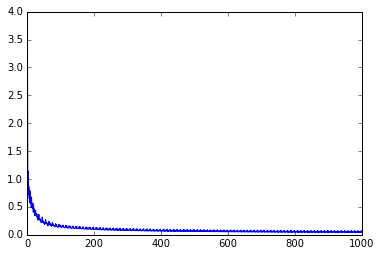

In [86]:
losses = []
N_EPOCHS = 1000
batch_size = 15
for epoch in range(N_EPOCHS):
    
    x_batch, y_batch = zip(*[ gen.next() for i in range(batch_size)])
    x_batch = np.stack(x_batch)[None,:].astype('float32')
    y_batch = np.stack(y_batch)[None,:].astype('float32')
    losses.append( train_func(x_batch,y_batch))
    if epoch%100==0:
        print "epoch:",epoch

plt.plot(losses)

In [87]:
pred_1_step = theano.function([X_seq_inp],pred_y_seq)

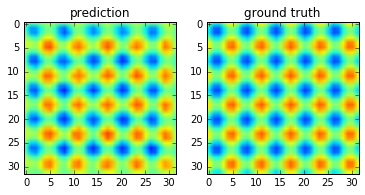

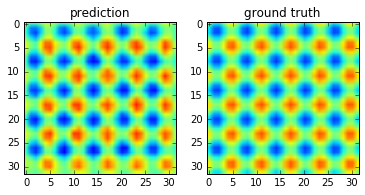

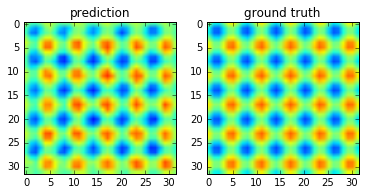

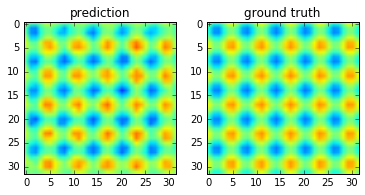

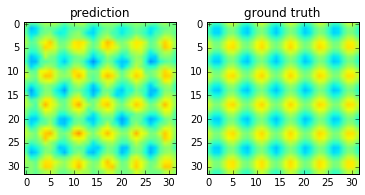

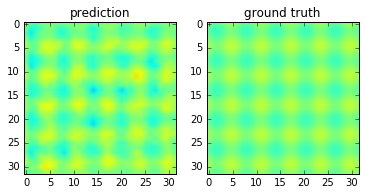

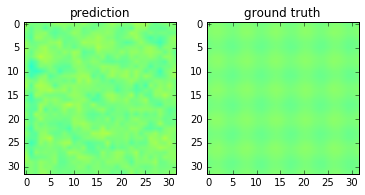

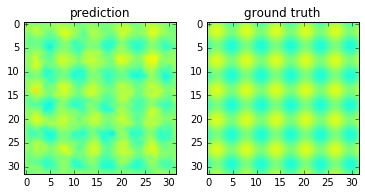

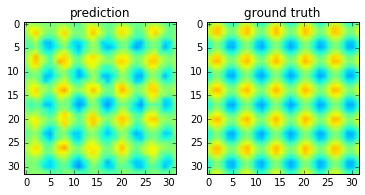

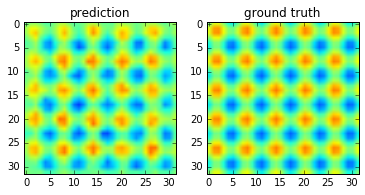

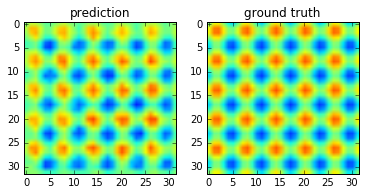

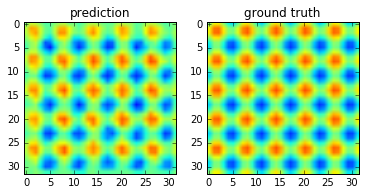

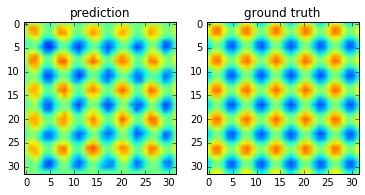

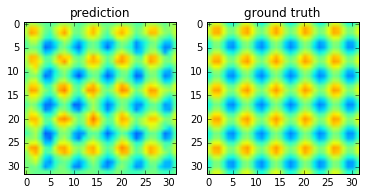

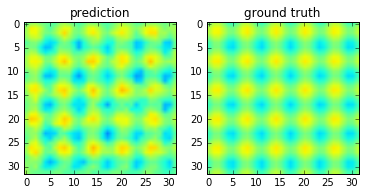

In [92]:
for i, img in enumerate(pred_1_step(x_batch)[0]):
    plt.subplot(121)
    plt.imshow(img,vmin=-3,vmax=3)
    plt.title('prediction')
    
    plt.subplot(122)
    plt.imshow(y_batch[0][i],vmin=-3,vmax=3)
    plt.title('ground truth')
    plt.show()

In [93]:
gen_states,gen_outputs = rec_generator.get_sequence_layers()

gen_seq = lasagne.layers.get_output(gen_outputs[0])

generate = theano.function([generator_init_var], gen_seq)

In [94]:
x_batch.shape

(1, 15, 32, 32)

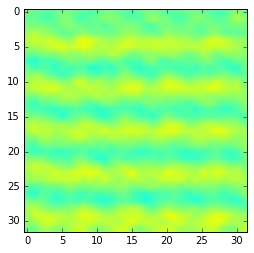

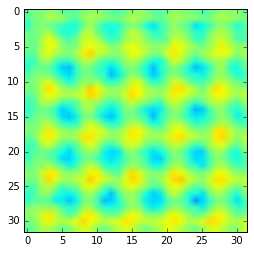

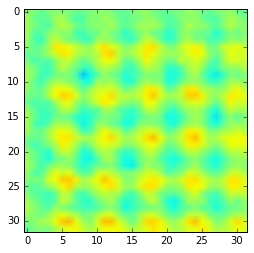

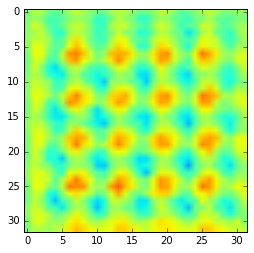

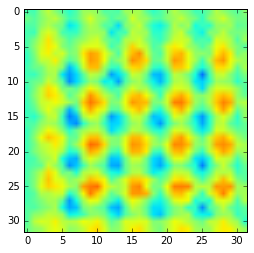

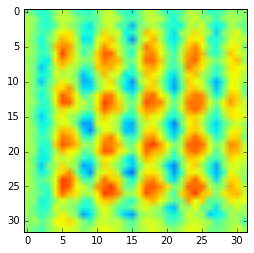

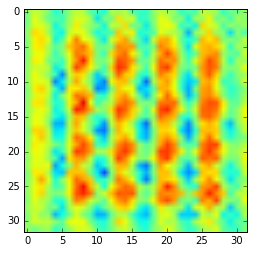

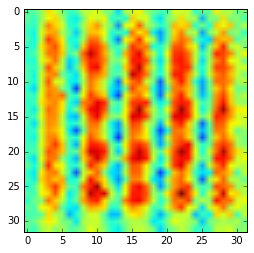

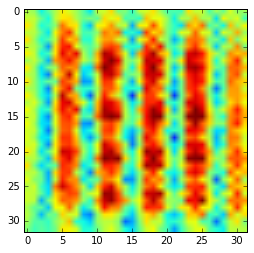

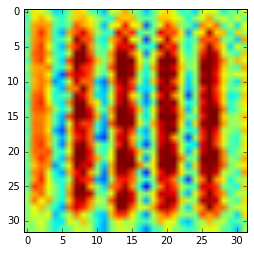

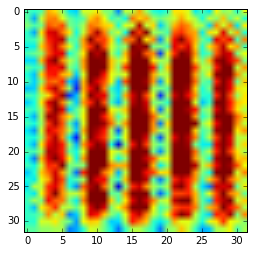

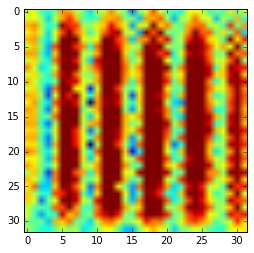

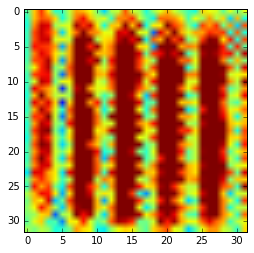

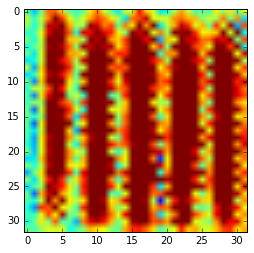

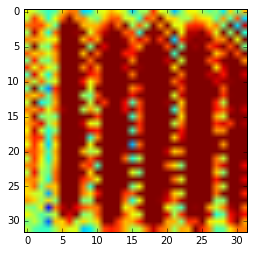

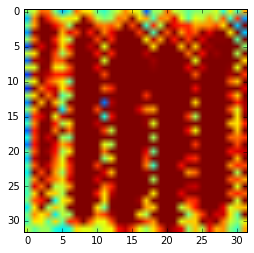

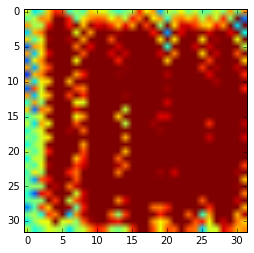

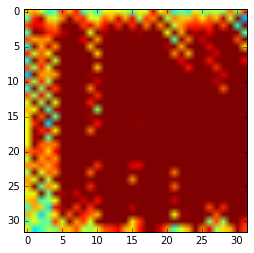

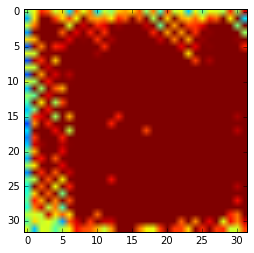

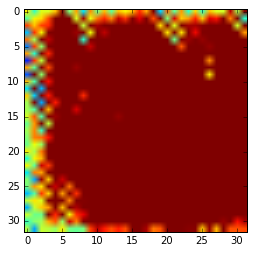

In [95]:
init= x_batch[:,0,None,]
for img in generate(init)[0,:,0]:
    plt.imshow(img,vmin=-3,vmax=3)
    plt.show()